# weighted ego network clustering of different sizes

In [1]:
import pandas as pd
import scipy
import matplotlib
import matplotlib.colors as mcolors
import os 

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
import glob
from scipy.spatial.distance import squareform
import numpy as np
import networkx as nx
from graspologic.match import graph_match
from sklearn import datasets, manifold
from matplotlib.pyplot import cm
import seaborn as sns
from adjustText import adjust_text
import scipy
from scipy import cluster


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph
from module.utils import load_object

In [3]:
from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance, combine_vecs
from module.gramchd.nhood import get_io_top_NM, get_io_top_M
# from src.nhood_vis import df_to_graph
from module.gramchd.nhood_vis import plot_two_graphs_overlay, plot_two_graphs_from_output
from module.utils import get_neighbourhood, get_w_threshold

from module.denclex.dendrogram_eval import get_clustering_stats, cluster_purity_test

In [4]:
import pandas as pd

from module.denclex.dendrograms_plotting import get_network_from_tree, get_adj_from_edgelist, generate_cluster_evolution
from module.denclex.tree_network import tree_search



In [5]:
datadate = '20231124'

nb_name = '01_weg_sizes'
save_things = False


In [6]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)
vnc_edges.loc[:,'attr'] = vnc_edges.weight.apply(lambda x: {'weight':x})
vnc_meta.bodyId = vnc_meta.bodyId.astype('str')


# open:

In [7]:
heminames = ['13B', '23B', '14A'] # sample hemilineages
n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values))
# n_ids = nexist_ids # all by all
n_ids = sorted(n_ids)[:]


In [8]:
len(n_ids)

1369

In [9]:

jobname = 'vnc_gmd_sample_hemi_job_M30_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
total_M30_vecs = combine_vecs(fpath_prefix)
total_M30_vecs = total_M30_vecs.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)

# arr_no = 1
# jobno = 0
# data_dir = f'./data/vnc/{datadate}_data/gmatching/{jobname}/array_{arr_no}/{jobname}_{arr_no}_{jobno}.parquet'

# hemis_M30_ew_dist_itharr_jthjob_df = pd.read_parquet(data_dir)


# get nhoods:

In [10]:
M=50

In [11]:
# heminames = ['12A', '02A', '00A', '09B']

# heminames = ['12A', '06B', '00A', '09B']


heminames = ['13B', '23B', '14A'] # sample hemilineages


In [12]:


n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values)) # the integers have the numpy.int64 datatype!
n_ids = sorted([str(i) for i in n_ids])[:]
len(n_ids)

1369

In [13]:
n_ids_meta = vnc_meta[vnc_meta['bodyId'].isin(n_ids)].copy(True).set_index('bodyId')
n_ids_meta.index = n_ids_meta.index.astype('str')
n_ids_ptn = get_neighbourhood(Ids=n_ids, df=vnc_edges)
pp_set = set(n_ids_ptn[['pre', 'post']].to_numpy().flatten())
n_ids_nhood = vnc_edges[vnc_edges['post'].isin(pp_set) & vnc_edges['pre'].isin(pp_set)].sort_index().copy(True)
# n_ids_nhood.loc[:,'attr'] = n_ids_nhood.weight.apply(lambda x: {'weight':x})


In [14]:
hemi_graphs = prepare_nhood_graphs(all_ids=n_ids, df=n_ids_nhood, edge_number=None, node_number=M, directed=True)
print(len(hemi_graphs))

1369


# Prep stats:

In [15]:
# def get_io_top_M(Id, df, M):
#     '''Gets the dataframe with the top M neurons by weight, irrespective of in or out.'''
#     source, sink = df.columns[:2]

#     pre = df.query(f'{sink}==@Id')[[source, 'weight']]
#     # print(pre)
#     post = df.query(f'{source}==@Id')[[sink, 'weight']]
#     # print(post)
#     pre.set_index(source).sort_values('weight')
#     summed_prepost = post.join(pre.set_index(source), on=sink, lsuffix='_post', rsuffix='_pre', how='outer').fillna(0)#.sort_values('weight_pre', ascending=False)
#     summed_prepost.rename(columns={sink:'id'}, inplace=True)
#     summed_prepost['total_weight'] = summed_prepost['weight_post'] + summed_prepost['weight_pre']
#     return summed_prepost.sort_values('total_weight', ascending=False).iloc[:M]


## nhood 

In [16]:
partner_dfs = []
int_n_ids = [int(i) for i in n_ids]

normed_partner_cum_sum_dfs = []
partner_cum_sum_dfs = []

for i in int_n_ids:
    # print(i)
    partner_df = get_io_top_M(Id=i, df=get_w_threshold(vnc_edges, thrshld=0), M=None).reset_index(drop=True)
    partner_cum_sum_df = partner_df.iloc[:,1:].cumsum(axis='index')
    total_weights = partner_df.iloc[:, 1:].sum(axis=0).to_dict()
    normed_partner_cum_sum_df = partner_cum_sum_df.div(total_weights) # normalised by total
    partner_dfs.append(partner_df)
    partner_cum_sum_dfs.append(partner_cum_sum_df)
    normed_partner_cum_sum_dfs.append(normed_partner_cum_sum_df)

# 2mins 22 

In [17]:
nM_stats = {}

for M in [15, 30, 50, 80, 100]:
    M_id_dict = {}
    for ind, val in enumerate(int_n_ids):
        #     print(ind, val, M)
            _df = normed_partner_cum_sum_dfs[ind]
            ith_check = min(len(_df)-1, M-1)
            M_id_dict[val] = normed_partner_cum_sum_dfs[ind].loc[ith_check].to_dict()
    n_ids_M_cumweight_df = pd.DataFrame.from_dict(M_id_dict, orient='index')
    n_ids_M_cumweight_df.index = n_ids_M_cumweight_df.index.astype(str)

    nM_stats[M] = n_ids_M_cumweight_df

In [18]:


colors = [(0, 'red'), (0.5, 'white'), (1, 'green')]

# Create a colormap
wcmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', colors)

## hemilineage

In [19]:
hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i
cinds_avoid_rg = list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:] 
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)


# Load data:

## M = 15

In [20]:
# M=15

In [21]:
# hemis_M30_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_M{M}_0_combined.parquet')

# hemis_M30_ew_dist_df = hemis_M30_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).drop_duplicates().reset_index(drop=True)

In [22]:
# jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

# fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
# files = glob.glob(fpath_prefix)
# hemis_M15_ew_dist_df = combine_vecs(fpath_prefix)
# hemis_M15_ew_dist_df = hemis_M15_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=30

In [23]:
M=30

In [24]:
# hemis_M30_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_M{M}_0_combined.parquet')

# hemis_M30_ew_dist_df = hemis_M30_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).drop_duplicates().reset_index(drop=True)

In [25]:
jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M30_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M30_ew_dist_df = hemis_M30_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=50

In [26]:
M=50

In [27]:
# hemis_M50_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_0_combined.parquet')

# hemis_M50_ew_dist_df = hemis_M50_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).reset_index(drop=True)

In [28]:
jobname = 'vnc_gmd_sample_hemi_job_M50_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M50_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M50_ew_dist_df = hemis_M50_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=80

In [29]:
M=80

In [30]:
# hemis_M80_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_M{M}_0_combined.parquet')

# hemis_M80_ew_dist_df = hemis_M80_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).drop_duplicates().reset_index(drop=True)

In [31]:
jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M80_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M80_ew_dist_df = hemis_M80_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=100

In [32]:
M=100

In [33]:
jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M100_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M100_ew_dist_df = hemis_M100_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


# Clustering visualisation:

In [34]:
msize_dist_df = {30: hemis_M30_ew_dist_df, 50:hemis_M50_ew_dist_df, 80:hemis_M80_ew_dist_df, 100:hemis_M100_ew_dist_df}

## horizontal:

In [35]:
# M=15
# dist_df = msize_dist_df[M]

# dist_type = 'euclidean_distance'

# method='ward'

# cond_dist = (dist_df[dist_type].values)
# Z = linkage(cond_dist, method=method) ####### linkage

# ind_to_id = [str(i) for i in n_ids]
# title = f'{heminames}, M ={M}, {dist_type}, method={method}'

# N_type_data= 2

# hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
# hemi_uniques = list(set(hemi_ind))
# numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
# for i, category in enumerate(hemi_uniques):
#     numeric_hemi_data[hemi_ind == category] = i

# cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
# colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# # colors = ['blue', 'orange', 'pink']
# # Create a colormap from the colors
# hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# # Plot the categorical data
# # method = 'ward'


# fig = plt.figure(figsize=(10, 3))
# fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

# gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
#                                    height_ratios=[10,5], hspace=0.05)
# gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
#                                                   height_ratios=[1,0],
#                                                   hspace=0)

# ax_col_dendrogram = fig.add_subplot(gs1[0])

# col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
# ax_col_dendrogram.set_axis_off()

# xind = col_dendrogram['leaves']

# xmin,xmax = ax_col_dendrogram.get_xlim()

# gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

# n_ids_cumweight_df = nM_stats[M]
# type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

# for i,(data,cmap, label) in enumerate(type_data):
#     ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
#     ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
#     ax.set_yticks([])
#     ax.set_ylabel(label, rotation=0, ha='right', va='center')
#     ax.set_xticks([])
#     plt.setp(ax.get_xticklabels(), visible=False)
# # plt.colorbar()
# # save=False
# if save_things:
#     plt.savefig(f'../figures/{datadate}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)
# # save=False

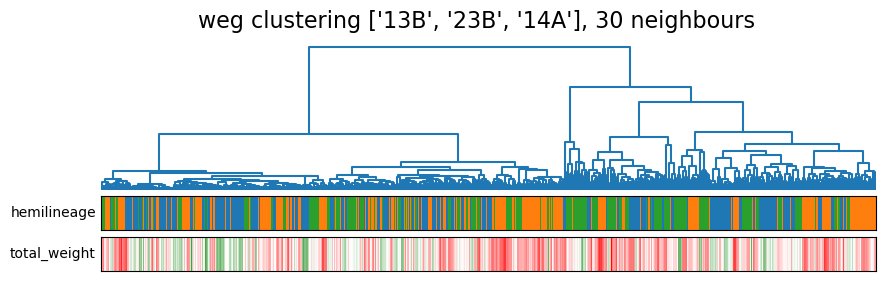

In [36]:
M=30
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

n_ids_cumweight_df = nM_stats[M]
type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)


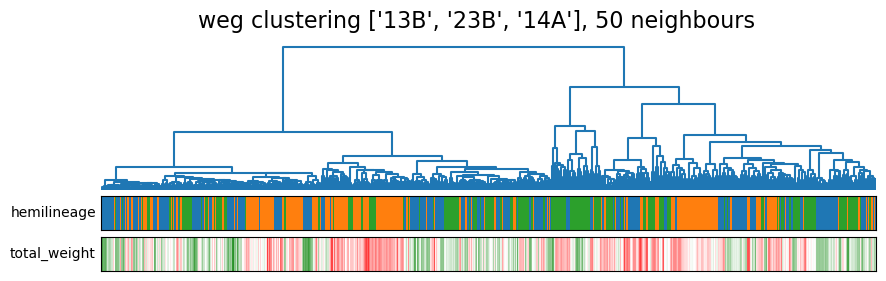

In [37]:
M=50
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

n_ids_cumweight_df = nM_stats[M]
type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)


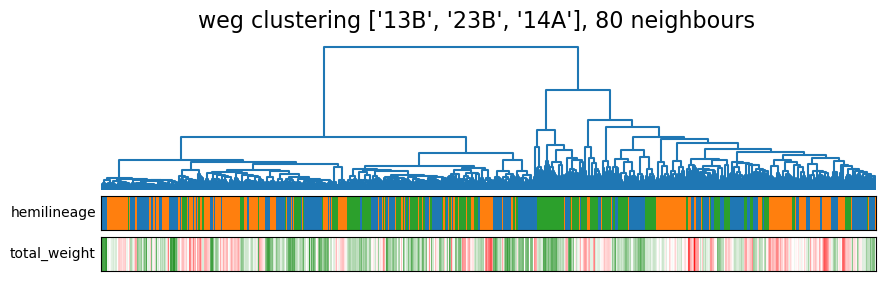

In [38]:
M=80
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)
# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])
n_ids_cumweight_df = nM_stats[M]


type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)


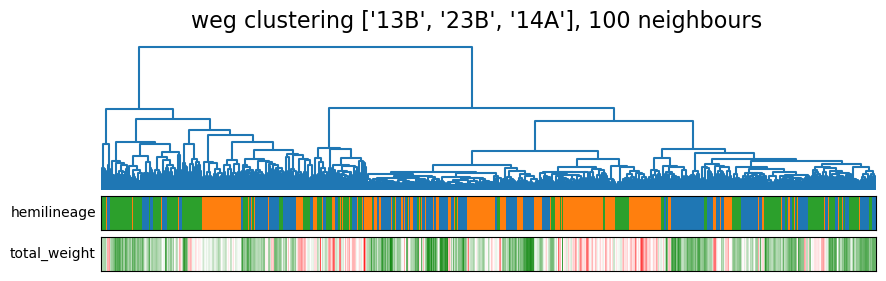

In [39]:
M=100
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)
# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])
n_ids_cumweight_df = nM_stats[M]


type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
# save=True
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)
